<a href="https://colab.research.google.com/github/youngmin5068/Medical_DeepLearning/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets
import torchvision

In [4]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

		# Convolution, Batch Normalization, ReLU 연산을 합친 함수
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
            )
            return layer

		# Contracting path
        # 572x572x1 => 568x568x64
        self.conv1 = nn.Sequential(
            CBR2d(1, 64, 3, 1),
            CBR2d(64, 64, 3, 1)
        )
		# 568x568x64 => 284x284x64 		
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


		# 284x284x64 => 280x280x128
        self.conv2 = nn.Sequential(
            CBR2d(64, 128, 3, 1),
            CBR2d(128, 128, 3, 1)
        )
		# 280x280x128 => 140x140x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


		# 140x140x128 => 136x136x256
        self.conv3 = nn.Sequential(
            CBR2d(128, 256, 3, 1),
            CBR2d(256, 256, 3, 1)
        )
		# 136x136x256 => 68x68x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


		# 68x68x256 => 64x64x512
        # Contracting path 마지막에 Dropout 적용
        self.conv4 = nn.Sequential(
            CBR2d(256, 512, 3, 1),
            CBR2d(512, 512, 3, 1),
            nn.Dropout(p=0.5)
        )
		# 64x64x512 => 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
		# Contracting path 끝
        
		
        # Bottlneck 구간
        # 32x32x512 => 28x28x1024
        self.bottleNeck = nn.Sequential(
            CBR2d(512, 1024, 3, 1),
            CBR2d(1024, 1024, 3, 1),
        )
		# Bottlneck 구간 끝


		# Expanding path
        # channel 수를 감소 시키며 Up-Convolution
		# 28x28x1024 => 56x56x512        
        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)


		# Up-Convolution 이후 channel = 512
        # Contracting path 중 같은 단계의 Feature map을 가져와 Up-Convolution 결과의 Feature map과 Concat 연산
        # => channel = 1024 가 됩니다.
        # forward 부분을 참고해주세요
        # 56x56x1024 => 52x52x512
        self.ex_conv1 = nn.Sequential(
            CBR2d(1024, 512, 3, 1),
            CBR2d(512, 512, 3, 1)
        )

		# 52x52x512 => 104x104x256
        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

		# 104x104x512 => 100x100x256
        self.ex_conv2 = nn.Sequential(
            CBR2d(512, 256, 3, 1),
            CBR2d(256, 256, 3, 1)
        )

		# 100x100x256 => 200x200x128
        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

		# 200x200x256 => 196x196x128
        self.ex_conv3 = nn.Sequential(
            CBR2d(256, 128, 3, 1),
            CBR2d(128, 128, 3, 1)
        )

		# 196x196x128 => 392x392x64
        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

		# 392x392x128 => 388x388x64
        self.ex_conv4 = nn.Sequential(
            CBR2d(128, 64, 3, 1),
            CBR2d(64, 64, 3, 1),

        )

		# 논문 구조상 output = 2 channel
	    # train 데이터에서 세포 / 배경을 검출하는것이 목표여서 class_num = 1로 지정
		# 388x388x64 => 388x388x1
        self.fc = nn.Conv2d(64, 1, kernel_size=1, stride=1)


    def forward(self, x):
    	# Contracting path
        # 572x572x1 => 568x568x64
        layer1 = self.conv1(x)
        
        # Max Pooling
        # 568x568x64 => 284x284x64
        out = self.pool1(layer1)

		# 284x284x64 => 280x280x128
        layer2 = self.conv2(out)
        
        # Max Pooling
        # 280x280x128 => 140x140x128
        out = self.pool2(layer2)

		# 140x140x128 => 136x136x256
        layer3 = self.conv3(out)
        
        # Max Pooling
        # 136x136x256 => 68x68x256
        out = self.pool3(layer3)

		# 68x68x256 => 64x64x512
        layer4 = self.conv4(out)
        
        # Max Pooling
        # 64x64x512 => 32x32x512
        out = self.pool4(layer4)

		# bottleneck 
        # 32x32x512 => 28x28x1024
        bottleNeck = self.bottleNeck(out)

		# Expanding path
        # 28x28x1024 => 56x56x512
        upconv1 = self.upconv1(bottleNeck)
        
        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 56x56x512 => 56x56x1024
        cat1 = torch.cat((transforms.CenterCrop((upconv1.shape[2], upconv1.shape[3]))(layer4), upconv1), dim=1)
        
        # 56x56x1024 => 52x52x512
        ex_layer1 = self.ex_conv1(cat1)

		# 52x52x512 => 104x104x256
        upconv2 = self.upconv2(ex_layer1)
        
        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 104x104x256 => 104x104x512
        cat2 = torch.cat((transforms.CenterCrop((upconv2.shape[2], upconv2.shape[3]))(layer3), upconv2), dim=1)
        
        # 104x104x512 => 100x100x256
        ex_layer2 = self.ex_conv2(cat2)

		# 100x100x256 => 200x200x128
        upconv3 = self.upconv3(ex_layer2)
        
        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 200x200x128 => 200x200x256
        cat3 = torch.cat((transforms.CenterCrop((upconv3.shape[2], upconv3.shape[3]))(layer2), upconv3), dim=1)
        
        # 200x200x256 => 196x196x128
        ex_layer3 = self.ex_conv3(cat3)

		# 196x196x128=> 392x392x64
        upconv4 = self.upconv4(ex_layer3)
        
        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 392x392x64 => 392x392x128
        cat4 = torch.cat((transforms.CenterCrop((upconv4.shape[2], upconv4.shape[3]))(layer1), upconv4), dim=1)
        
        # 392x392x128 => 388x388x64
        out = self.ex_conv4(cat4)

		# 388x388x64 => 388x388x1
        out = self.fc(out)
        return out

# Dataset & transform

In [5]:
import numpy as np
from PIL import Image

(512, 512)

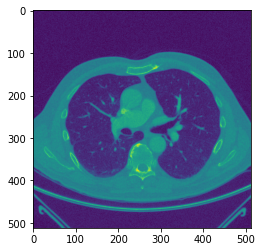

In [6]:
im1 = Image.open(os.path.join('/content/drive/MyDrive/2d_images','/content/drive/MyDrive/2d_images/ID_0000_Z_0142.tif'))


im1 = np.asarray(im1)/255.0
plt.imshow(im1)
im1.shape


In [7]:
input_data = os.listdir('/content/drive/MyDrive/2d_images')
label_data = os.listdir('/content/drive/MyDrive/2d_masks')

input_list = sorted([os.path.join('/content/drive/MyDrive/2d_images',f) for f in input_data])
label_list = sorted([os.path.join('/content/drive/MyDrive/2d_masks',f)for f in label_data if not f.endswith('(1).tif')])

input_list[0], label_list[0]

('/content/drive/MyDrive/2d_images/ID_0000_Z_0142.tif',
 '/content/drive/MyDrive/2d_masks/ID_0000_Z_0142.tif')

In [8]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import PIL
print('PIL',PIL.__version__)

PIL 7.1.2


In [10]:
img = Image.open(label_list[0])
img = np.asarray(img)
img.shape

(512, 512)

In [11]:
train_input_filepaths = input_list[:200]
val_input_filepaths = input_list[200:]

train_label_filepaths = label_list[:200]
val_label_filepaths = label_list[200:]
print(len(train_input_filepaths),len(val_input_filepaths))

200 67


In [12]:
class UNetDataset(Dataset):
  def __init__(self, file_list,label_list,transform=None,phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.label_list = label_list
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  #data load
  def __getitem__(self,index):
    img_path = self.file_list[index]

    img = Image.open(img_path)
    img = np.asarray(img)/255.0
    img = Image.fromarray(img)
    img = img.resize((572,572))
    img_transformed = self.transform(img,self.phase)

    
    label = Image.open(self.label_list[index])

    label = np.asarray(label)
    label = label/255.0
    label = Image.fromarray(label)
    label = label.resize((388,388))
 
    img_label_transformed = self.transform(label,self.phase)

    return img_transformed, img_label_transformed

In [13]:
size = 572
mean = (0.5,)
std = (0.5,)
batch_size = 4

In [14]:
class ImageTransform():
  def __init__(self, resize, mean,std):
    self.data_transform = {
        'train': transforms.Compose([
            #transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ]),

        'val': transforms.Compose([
            #transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
    }

  def __call__(self, img, phase):
    return self.data_transform[phase](img)

In [15]:
train_dataset = UNetDataset(
    file_list = train_input_filepaths,
    label_list = train_label_filepaths,
    transform= ImageTransform(size,mean,std),
    phase='train'
)
val_dataset = UNetDataset(
    file_list = train_input_filepaths,
    label_list = train_label_filepaths,
    transform= ImageTransform(size,mean,std),
    phase='val'
)

In [16]:
print(val_dataset.__getitem__(0)[0].size(),val_dataset.__getitem__(0)[1].size())

torch.Size([1, 572, 572]) torch.Size([1, 388, 388])


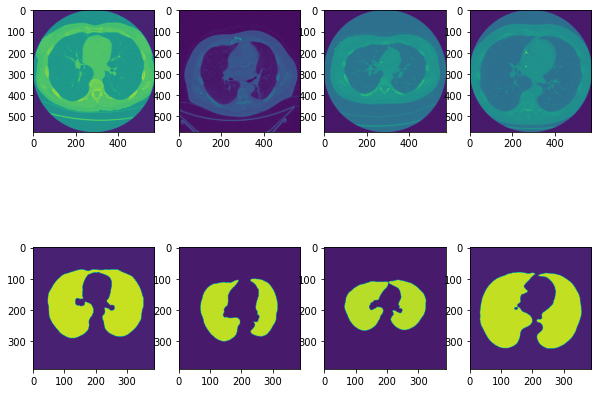

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True,num_workers=2)

dataloader_dict = {'train':train_dataloader,'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, labels = batch_iterator.next()

plt.figure(figsize=(10,8))
for i in range(0,4):
  plt.subplot(2,4,i+1)
  plt.imshow(inputs[i].permute(1, 2, 0).squeeze())
  plt.subplot(2,4,i+1+4)
  plt.imshow(labels[i].permute(1,2,0).squeeze())

In [18]:
lr = 1e-3
batch_size=4
num_epoch=3

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
Unet = UNet().to(device)

In [ ]:
from torchsummary import summary

summary(Unet,input_size=(1,572,572))

In [22]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad) # numel : 파라미터 수 알려줌

par = count_parameters(Unet)
par

31042369

In [23]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(Unet.parameters(),lr=lr)

In [24]:
import time

In [25]:
!pip install --user tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from tqdm import tqdm_notebook as tqdm

In [27]:
data_dir = '/content/drive/MyDrive/Unet/data'
ckpt_dir = '/content/drive/MyDrive/Unet/checkpoint'
log_dir = '/content/drive/MyDrive/Unet/log'

In [28]:
from torch.utils.tensorboard import SummaryWriter
# 기타 variables 설정
num_train = len(train_dataset)
num_val = len(val_dataset)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/batch_size)

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# Tensorbord
writer_train = SummaryWriter(log_dir=os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))

In [30]:
import os

In [31]:

def save(ckpt_dir,net,optim,epoch):
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
  torch.save({'net':Unet.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

In [41]:
# 네트워크 학습시키기
start_epoch = 0
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = Unet, optim = optimizer) # 저장된 네트워크 불러오기


for epoch in range(start_epoch+1,num_epoch +1):
    Unet.train()
    loss_arr = []

    for batch, data in enumerate(train_dataloader,1): # 1은 뭐니 > index start point
        # forward
        inputs = data[0].to(device)
        labels = data[1].to(device)   # 데이터 device로 올리기     
        epoch_loss = 0.0
        output = Unet(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = criterion(output, labels)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        epoch_loss += loss.item() * inputs.size(0)
        # save loss
        loss_arr += [loss.item()]

        print('TRAIN : epoch {} / {} | Batch {} / {} | Loss {:.4f}'.format(epoch,num_epoch,batch,num_train_for_epoch,epoch_loss))

        # tensorbord에 결과값들 저정하기
        labels = fn_tonumpy(labels)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('labels', labels, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('inputs', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    
    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        Unet.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in tqdm(enumerate(val_dataloader,1)):
            # forward
            inputs = data[0].to('cuda')
            labels = data[1].to('cuda')
            output = Unet(inputs)

            # loss 
            loss = criterion(output,labels)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04d | Loss %04d'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            labels = fn_tonumpy(labels)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('labels', labels, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

TRAIN : epoch 1 / 3 | Batch 1 / 50.0 | Loss -2.1927
TRAIN : epoch 1 / 3 | Batch 2 / 50.0 | Loss -1.8425
TRAIN : epoch 1 / 3 | Batch 3 / 50.0 | Loss -2.5948
TRAIN : epoch 1 / 3 | Batch 4 / 50.0 | Loss -2.9012
TRAIN : epoch 1 / 3 | Batch 5 / 50.0 | Loss -2.7546
TRAIN : epoch 1 / 3 | Batch 6 / 50.0 | Loss -3.2311
TRAIN : epoch 1 / 3 | Batch 7 / 50.0 | Loss -2.8855
TRAIN : epoch 1 / 3 | Batch 8 / 50.0 | Loss -3.7957
TRAIN : epoch 1 / 3 | Batch 9 / 50.0 | Loss -3.5958
TRAIN : epoch 1 / 3 | Batch 10 / 50.0 | Loss -3.9650
TRAIN : epoch 1 / 3 | Batch 11 / 50.0 | Loss -3.1839
TRAIN : epoch 1 / 3 | Batch 12 / 50.0 | Loss -3.9284
TRAIN : epoch 1 / 3 | Batch 13 / 50.0 | Loss -3.9073
TRAIN : epoch 1 / 3 | Batch 14 / 50.0 | Loss -3.8365
TRAIN : epoch 1 / 3 | Batch 15 / 50.0 | Loss -4.4829
TRAIN : epoch 1 / 3 | Batch 16 / 50.0 | Loss -4.4881
TRAIN : epoch 1 / 3 | Batch 17 / 50.0 | Loss -4.5146
TRAIN : epoch 1 / 3 | Batch 18 / 50.0 | Loss -4.0895
TRAIN : epoch 1 / 3 | Batch 19 / 50.0 | Loss -5.1194
TR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

valid : epoch 0001 / 0003 | Batch 0001 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0002 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0003 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0004 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0005 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0006 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0007 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0008 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0009 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0010 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0011 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0012 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0013 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0014 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0015 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0016 \ 0050 | Loss -002
valid : epoch 0001 / 0003 | Batch 0017 \ 0050 | Loss -002
valid : epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'TiffImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)


KeyboardInterrupt: ignored